<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

In [196]:
from IPython.display import YouTubeVideo

# YouTubeVideo('Jml7NVYm8cs')

In [197]:
%pwd

'/home/belder/Codes/Lambda/Unit4/Sprint1/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [198]:
import pandas as pd
from pdb import set_trace as st

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [199]:
# Start here 

## 1- Preproccessing

### 1-1 removing "star rating" from "star_rating" column

In [200]:
# removing "star rating" from "star_rating" column
shops["star_rating_float"] = shops["star_rating"].str.slice(start=1, stop=4).astype(float)
shops

,coffee_shop_name,full_review_text,star_rating,star_rating_float
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,5.0
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,4.0
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,4.0
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,2.0
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,4.0
...,...,...,...,...
7611,The Steeping Room,2/19/2015 I actually step into this restauran...,4.0 star rating,4.0
7612,The Steeping Room,"1/21/2016 Ok, The Steeping Room IS awesome. H...",5.0 star rating,5.0
7613,The Steeping Room,"4/30/2015 Loved coming here for tea, and the ...",4.0 star rating,4.0
7614,The Steeping Room,8/2/2015 The food is just average. The booths...,3.0 star rating,3.0


### 1-2 extracting dates, text and check-in count from "full_review_text" column

In [201]:
# creating "review_date" column

splited_column = shops["full_review_text"].str.split(" ")
date_column_string = splited_column.apply(lambda x: x[1])
date_column_datetime = pd.to_datetime(date_column_string, infer_datetime_format=True)
shops["review_date"] = date_column_datetime
shops

,coffee_shop_name,full_review_text,star_rating,star_rating_float,review_date
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,5.0,2016-11-25
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,4.0,2016-12-02
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,4.0,2016-11-30
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,2.0,2016-11-25
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,4.0,2016-12-03
...,...,...,...,...,...
7611,The Steeping Room,2/19/2015 I actually step into this restauran...,4.0 star rating,4.0,2015-02-19
7612,The Steeping Room,"1/21/2016 Ok, The Steeping Room IS awesome. H...",5.0 star rating,5.0,2016-01-21
7613,The Steeping Room,"4/30/2015 Loved coming here for tea, and the ...",4.0 star rating,4.0,2015-04-30
7614,The Steeping Room,8/2/2015 The food is just average. The booths...,3.0 star rating,3.0,2015-08-02


In [202]:
# creating "reivew_checkin" column

rows_of_reviews_with_checkin = splited_column.apply(lambda x: x[3]).str.contains("check-in")
shops["review_checkin"] = splited_column[rows_of_reviews_with_checkin].apply(lambda x: x[2])
shops

,coffee_shop_name,full_review_text,star_rating,star_rating_float,review_date,review_checkin
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,5.0,2016-11-25,1
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,4.0,2016-12-02,NaN
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,4.0,2016-11-30,1
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,2.0,2016-11-25,NaN
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,4.0,2016-12-03,1
...,...,...,...,...,...,...
7611,The Steeping Room,2/19/2015 I actually step into this restauran...,4.0 star rating,4.0,2015-02-19,NaN
7612,The Steeping Room,"1/21/2016 Ok, The Steeping Room IS awesome. H...",5.0 star rating,5.0,2016-01-21,NaN
7613,The Steeping Room,"4/30/2015 Loved coming here for tea, and the ...",4.0 star rating,4.0,2015-04-30,NaN
7614,The Steeping Room,8/2/2015 The food is just average. The booths...,3.0 star rating,3.0,2015-08-02,NaN


In [203]:
# creating correct "review_text" column
shops["review_text"] = ""

for index, row in shops.iterrows():
    splited_review = row["full_review_text"].split(" ")
    if rows_of_reviews_with_checkin.iloc[index]:
        shops["review_text"][index] = " ".join(splited_review[4:])
    else:
        shops["review_text"][index] = " ".join(splited_review[2:])
        
shops

/home/belder/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/belder/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,coffee_shop_name,full_review_text,star_rating,star_rating_float,review_date,review_checkin,review_text
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,5.0,2016-11-25,1,Love love loved the atmosphere! Every corner o...
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,4.0,2016-12-02,NaN,"Listed in Date Night: Austin, Ambiance in Aust..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,4.0,2016-11-30,1,Listed in Brunch Spots I loved the eclectic an...
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,2.0,2016-11-25,NaN,Very cool decor! Good drinks Nice seating How...
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,4.0,2016-12-03,1,They are located within the Northcross mall sh...
...,...,...,...,...,...,...,...
7611,The Steeping Room,2/19/2015 I actually step into this restauran...,4.0 star rating,4.0,2015-02-19,NaN,I actually step into this restaurant by chance...
7612,The Steeping Room,"1/21/2016 Ok, The Steeping Room IS awesome. H...",5.0 star rating,5.0,2016-01-21,NaN,"Ok, The Steeping Room IS awesome. How do they ..."
7613,The Steeping Room,"4/30/2015 Loved coming here for tea, and the ...",4.0 star rating,4.0,2015-04-30,NaN,"Loved coming here for tea, and the atmosphere ..."
7614,The Steeping Room,8/2/2015 The food is just average. The booths...,3.0 star rating,3.0,2015-08-02,NaN,The food is just average. The booths didn't fe...


In [204]:
# Dropping extra column

shops = shops.drop(["full_review_text", "star_rating"], axis=1)
shops

,coffee_shop_name,star_rating_float,review_date,review_checkin,review_text
0,The Factory - Cafe With a Soul,5.0,2016-11-25,1,Love love loved the atmosphere! Every corner o...
1,The Factory - Cafe With a Soul,4.0,2016-12-02,NaN,"Listed in Date Night: Austin, Ambiance in Aust..."
2,The Factory - Cafe With a Soul,4.0,2016-11-30,1,Listed in Brunch Spots I loved the eclectic an...
3,The Factory - Cafe With a Soul,2.0,2016-11-25,NaN,Very cool decor! Good drinks Nice seating How...
4,The Factory - Cafe With a Soul,4.0,2016-12-03,1,They are located within the Northcross mall sh...
...,...,...,...,...,...
7611,The Steeping Room,4.0,2015-02-19,NaN,I actually step into this restaurant by chance...
7612,The Steeping Room,5.0,2016-01-21,NaN,"Ok, The Steeping Room IS awesome. How do they ..."
7613,The Steeping Room,4.0,2015-04-30,NaN,"Loved coming here for tea, and the atmosphere ..."
7614,The Steeping Room,3.0,2015-08-02,NaN,The food is just average. The booths didn't fe...


## 2- NLP

### 2-1 Lemmatization

In [208]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [213]:
# Tokenizer Pipe

tokens = []

""" Make them tokens """
for doc in tokenizer.pipe(shops['review_text'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

shops['tokens'] = tokens

In [216]:
from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [217]:
wc = count(shops['tokens'])

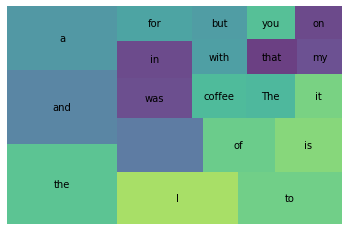

In [218]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [220]:
# Spacy's Default Stop Words
STOP_WORDS = nlp.Defaults.stop_words

In [226]:
tokens = []

for doc in tokenizer.pipe(shops['review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens
shops["tokens"]

0       [love, love, loved, atmosphere!, corner, coffe...
1       [listed, date, night:, austin,, ambiance, aust...
2       [listed, brunch, spots, loved, eclectic, homey...
3       [cool, decor!, good, drinks, nice, seating,  ,...
4       [located, northcross, mall, shopping, center, ...
                              ...                        
7611    [actually, step, restaurant, chance, favorites...
7612    [ok,, steeping, room, awesome., great, menu, i...
7613    [loved, coming, tea,, atmosphere, pretty, fres...
7614    [food, average., booths, didn't, feel, clean.,...
7615    [finally, stopped, lunch, colleague, i'm, glad...
Name: tokens, Length: 7616, dtype: object

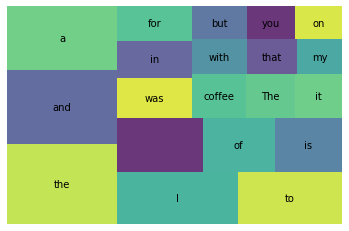

In [224]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

